# ShopTalk – Image Captioning Pipeline (BLIP & CLIP)

**Project:** ShopTalk – AI-Powered Shopping Assistant  
**Dataset:** [Amazon Berkeley Objects (ABO)](https://amazon-berkeley-objects.s3.amazonaws.com/index.html)  
**Author:** Balaji Gurusala  
**Notebook Scope:** T000c from `.spec/tasks.md`  
**Prerequisite:** `01-shoptalk-eda.ipynb` must have been run (produces `shoptalk_abo_cleaned.pkl`)  
**Environment:** Kaggle GPU (T4/P100) recommended; also works on Mac (MPS) or CPU (slower)

---

### Purpose

The problem statement requires **Image Captioning** to augment product descriptions with visual information.  
From the EDA we know:

| EDA Finding | Implication for This Notebook |
|-------------|------------------------------|
| `product_description` is **97.3% missing** | Text data is sparse – image captions become a critical text source |
| `bullet_point` is the best text field (89% complete, median 46 words) | Captions will supplement bullet_point, not replace it |
| **99.6%** of products (9,190/9,223) have valid image paths | Almost every product can be captioned |
| Images are 256px thumbnails in `data/images/small/{prefix}/{hash}.jpg` | Small enough for fast batch inference |

### Challenge: Object-of-Interest Extraction

Product images may contain background objects (tables, walls, floors) that confuse unconditional captioning.  
Example: A curtain product was captioned as "a wooden table" because BLIP focused on the table in the background.  
**Solution:** Use zero-shot object detection (OWL-ViT) to locate the product before captioning.

### Approach: Detect-then-Caption

1. **OWL-ViT** (`google/owlvit-base-patch32`) – Zero-shot object detection using product title/category as query to locate and crop the product region.  
2. **BLIP** (`Salesforce/blip-image-captioning-base`) – Caption the **cropped** product region (falls back to full image if detection fails).  
3. **CLIP** (`openai/clip-vit-base-patch32`) – Validate image-text alignment quality.  
4. **Output** – `enriched_products.csv` with `image_caption` and `detection_confidence` columns.

### Notebook Outline

1. **Step 0** – Environment Setup & Hardware Detection  
2. **Step 1** – Load Cleaned Data from EDA  
3. **Step 2** – Load BLIP Model (once, GPU-aware)  
4. **Step 3** – Batch Image Captioning  
5. **Step 4** – Caption Quality Analysis  
6. **Step 5** – CLIP Embeddings & Similarity (Optional)  
7. **Step 6** – Export Enriched Dataset  
8. **Summary & Next Steps**

---

## Step 0 – Environment Setup & Hardware Detection

In [18]:
# ============================================================
# Step 0: Environment Setup & Hardware Detection
# ============================================================
# Per constitution: Code must detect mps (Mac) vs cuda (Kaggle/AWS) dynamically.

import os
import sys
import time
import json
import gzip
import warnings
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from PIL import Image

import torch
from transformers import (
    BlipProcessor,
    BlipForConditionalGeneration,
    CLIPProcessor,
    CLIPModel,
    OwlViTProcessor,
    OwlViTForObjectDetection,
)

from IPython.display import display, Image as IPImage, HTML

# Settings
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams["figure.dpi"] = 120
pd.set_option("display.max_colwidth", 120)

# --- Hardware Detection ---
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    GPU_NAME = torch.cuda.get_device_name(0)
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    GPU_NAME = "Apple Silicon (MPS)"
else:
    DEVICE = torch.device("cpu")
    GPU_NAME = "CPU (no GPU)"

print(f"Python {sys.version}")
print(f"PyTorch {torch.__version__}")
print(f"Device: {DEVICE} ({GPU_NAME})")
print(f"\nEnvironment ready.")

Python 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch 2.8.0+cu126
Device: cuda (Tesla T4)

Environment ready.


In [75]:
# ============================================================
# Configuration
# ============================================================

# --- Paths ---
# On Kaggle: data is in /kaggle/working/ or ./data/
# Locally: data is in ./data/ relative to notebooks/
DATA_DIR = Path("./data")
IMAGE_BASE = DATA_DIR / "images" / "small"

# EDA output (from 01-shoptalk-eda.ipynb)
# Try Kaggle path first, then local
EDA_PKL_PATHS = [
    Path("/kaggle/working/shoptalk_abo_cleaned.pkl"),
    Path("./shoptalk_abo_cleaned.pkl"),
    DATA_DIR / "shoptalk_abo_cleaned.pkl",
]

# Output – always save to /kaggle/working/ so the next notebook can find them
OUTPUT_DIR = "/kaggle/working/"

# --- Model Config ---
BLIP_MODEL_ID = "Salesforce/blip-image-captioning-base"
CLIP_MODEL_ID = "openai/clip-vit-base-patch32"
OWLVIT_MODEL_ID = "google/owlvit-base-patch32"

# --- Processing Config ---
BATCH_SIZE = 32 if DEVICE.type == "cuda" else 4
MAX_CAPTION_TOKENS = 64
SAMPLE_SIZE = None  # None = process all; set to e.g. 100 for quick test

# --- Detection Config ---
DETECTION_CONFIDENCE_THRESHOLD = 0.1  # Minimum OWL-ViT confidence to crop
CROP_PADDING_RATIO = 0.05  # Pad the bounding box by 5% on each side

print(f"IMAGE_BASE:    {IMAGE_BASE}")
print(f"OUTPUT_DIR:    {OUTPUT_DIR}")
print(f"BLIP Model:    {BLIP_MODEL_ID}")
print(f"CLIP Model:    {CLIP_MODEL_ID}")
print(f"Batch Size:    {BATCH_SIZE}")
print(f"Sample Size:   {SAMPLE_SIZE or 'ALL'}")

IMAGE_BASE:    data/images/small
OUTPUT_DIR:    /kaggle/working
BLIP Model:    Salesforce/blip-image-captioning-base
CLIP Model:    openai/clip-vit-base-patch32
Batch Size:    32
Sample Size:   ALL


---

## Step 1 – Load Cleaned Data from EDA

We load the cleaned DataFrame produced by `01-shoptalk-eda.ipynb`.  
Key columns we need: `item_id`, `item_name_flat`, `main_image_id`, `path`, `bullet_point_flat`, `product_type_flat`, `brand_flat`.

In [30]:
# 1. Unzip silently to the working directory
!unzip -o -q ../input/notebooks/balajigurusala/01-shoptalk-eda/_output_.zip -d /kaggle/working/

# 2. Define the path where the file now sits
pkl_path = Path("/kaggle/working/shoptalk_abo_cleaned.pkl")

# 3. Load the data
if pkl_path.exists():
    df = pd.read_pickle(pkl_path)
    print(f"✓ Success! Loaded {len(df):,} rows from {pkl_path}")
else:
    print("⚠️ File still not found in /kaggle/working/")

# Preview to ensure it's correct
df.head()

✓ Success! Loaded 9,223 rows from /kaggle/working/shoptalk_abo_cleaned.pkl


,brand,bullet_point,color,item_id,item_name,model_name,model_number,model_year,product_type,style,...,item_keywords_flat,product_description_flat,product_type_flat,item_weight_flat,item_length_flat,title_length,desc_word_count,keyword_count,image_id,path
0,"[{'language_tag': 'nl_NL', 'value': 'find.'}]","[{'language_tag': 'nl_NL', 'value': 'Schoen in Loafer-stijl'}, {'language_tag': 'nl_NL', 'value': 'Platform hak'}, {...","[{'language_tag': 'nl_NL', 'value': 'Veelkleurig Vrouw Blauw'}]",B06X9STHNG,"[{'language_tag': 'nl_NL', 'value': 'Amazon-merk - vinden. Dames Leder Gesloten Teen Hakken,Veelkleurig Vrouw Blauw,...","[{'language_tag': 'nl_NL', 'value': '37753'}]",[{'value': '12-05-04'}],[{'value': 2017}],[{'value': 'SHOES'}],"[{'language_tag': 'nl_NL', 'value': 'Gesloten-teen pompen'}]",...,block heel shoes | loafer shoes | loafers | metallic shoes | womens block heel shoes | womens fashion | womens loafe...,None,SHOES,NaN,NaN,83,0,10,81iZlv3bjpL,8c/8ccb5859.jpg
1,"[{'language_tag': 'es_MX', 'value': 'AmazonBasics'}]","[{'language_tag': 'es_MX', 'value': 'White Powder Coat Finish'}, {'language_tag': 'es_MX', 'value': '55-Lbs max weig...","[{'language_tag': 'es_MX', 'value': 'White Powder Coat'}]",B07P8ML82R,"[{'language_tag': 'es_MX', 'value': '22"" Bottom Mount Drawer Slides, White Powder Coat, 10 Pairs'}]",NaN,[{'value': 'AB5013-R22-10'}],NaN,[{'value': 'HARDWARE'}],"[{'language_tag': 'es_MX', 'value': '10 pares'}]",...,22 | Pistola | Montaje bajo | diapositivas | Extensión | Oculto | Deslizadores | Almacenamiento | Bola | Guías | cie...,None,HARDWARE,1.45000,22.00,59,0,43,619y9YG9cnL,9f/9f76d27b.jpg
2,"[{'language_tag': 'en_AE', 'value': 'AmazonBasics'}]","[{'language_tag': 'en_AE', 'value': '3D printer filament with 1.75mm diameter + / - .05mm; designed to fit most comm...","[{'language_tag': 'en_AE', 'value': 'Translucent Yellow'}]",B07H9GMYXS,"[{'language_tag': 'en_AE', 'value': 'AmazonBasics PETG 3D Printer Filament, 1.75mm, 1 kg Spool 1.75mm AMG10528516-10'}]",NaN,[{'value': 'AMG10528516-10'}],NaN,[{'value': 'MECHANICAL_COMPONENTS'}],"[{'language_tag': 'en_AE', 'value': '1-Pack'}]",...,3d printer filament | petg printer filament | petg filament | 1.75mm printer filament | 1kg spool printer filament |...,None,MECHANICAL_COMPONENTS,2.20000,9.21,79,0,10,81NP7qh2L6L,66/665cc994.jpg
3,"[{'language_tag': 'en_GB', 'value': 'Stone & Beam'}]",NaN,"[{'language_tag': 'en_GB', 'value': 'Stone Brown'}]",B07CTPR73M,"[{'language_tag': 'en_GB', 'value': 'Stone & Beam Stone Brown Swatch, 25020039-01'}]",NaN,[{'value': '25020039-01'}],NaN,[{'value': 'SOFA'}],NaN,...,love | loveseat | queen | for | couch | chesterfield | rolled | couches | button | homelegance | red | daybed | and ...,None,SOFA,0.10000,NaN,44,0,91,61Rp4qOih9L,b4/b4f9d0cc.jpg
4,"[{'language_tag': 'en_AU', 'value': 'The Fix'}]","[{'language_tag': 'en_AU', 'value': 'Embroidered flowers bloom against understated tan suede in this backless loafer...","[{'language_tag': 'en_AU', 'standardized_values': ['Brown'], 'value': 'Havana Tan'}]",B01MTEI8M6,"[{'language_tag': 'en_AU', 'value': 'The Fix Amazon Brand Women's French Floral Embroidery Slide Slip-on Loafer, Hav...",NaN,[{'value': '880071Havana Tan'}],[{'value': 2017}],[{'value': 'SHOES'}],"[{'language_tag': 'en_AU', 'value': 'French Loafer Slide'}]",...,zapatos shoe para de ladies mujer womans mocasines | designer fashion moda cocktail work wear business office sexy s...,None,SHOES,0.41875,NaN,96,0,2,714CmIfKIYL,2b/2b1c2516.jpg


In [31]:
# ============================================================
# Step 1: Load Cleaned Data from EDA
# ============================================================

# Update your path list to this:
df = None
for pkl_path in EDA_PKL_PATHS:
    if pkl_path.exists():
        print(f"\u2713 Loading cleaned data from: {pkl_path}")
        df = pd.read_pickle(pkl_path)
        break

if df is None:
    print("\u26a0\ufe0f EDA pickle not found. Attempting to load from CSV fallback...")
    csv_fallbacks = [
        Path("../input/01-shoptalk-eda/shoptalk_abo_cleaned.csv"),  # New Input Path
        Path("/kaggle/working/shoptalk_abo_cleaned.csv"),
        Path("./shoptalk_abo_cleaned.csv")
    ]
    for csv_path in csv_fallbacks:
        if csv_path.exists():
            print(f"\u2713 Loading from CSV: {csv_path}")
            df = pd.read_csv(csv_path)
            break

assert df is not None, (
    "Could not find EDA output. Run 01-shoptalk-eda.ipynb first, "
    "or place shoptalk_abo_cleaned.pkl in one of the expected paths."
)

print(f"\nDataset shape: {df.shape[0]:,} rows \u00d7 {df.shape[1]} columns")
print(f"\nKey columns:")
for col in ["item_id", "item_name_flat", "main_image_id", "path",
            "bullet_point_flat", "product_type_flat", "brand_flat"]:
    present = col in df.columns
    non_null = df[col].notna().sum() if present else 0
    print(f"  {col:30s} {'\u2713' if present else '\u2717'}  ({non_null:,} non-null)")

# Filter to products with valid image paths
df_with_images = df[df["path"].notna()].copy()
print(f"\nProducts with image paths: {len(df_with_images):,} / {len(df):,}")

✓ Loading cleaned data from: /kaggle/working/shoptalk_abo_cleaned.pkl

Dataset shape: 9,223 rows × 47 columns

Key columns:
  item_id                        ✓  (9,223 non-null)
  item_name_flat                 ✓  (9,223 non-null)
  main_image_id                  ✓  (9,190 non-null)
  path                           ✓  (9,190 non-null)
  bullet_point_flat              ✓  (8,199 non-null)
  product_type_flat              ✓  (9,223 non-null)
  brand_flat                     ✓  (9,220 non-null)

Products with image paths: 9,190 / 9,223


In [49]:
# --- Verify image files exist on disk ---
def verify_image_path(rel_path: str, base: Path) -> bool:
    """Check if a relative image path resolves to an existing file.

    Args:
        rel_path: Relative path from images.csv.gz (e.g. '8c/8ccb5859.jpg').
        base: Base directory for images.

    Returns:
        True if file exists.
    """
    return (base / str(rel_path)).exists()


# Quick spot-check: verify first 50 paths
sample_paths = df_with_images["path"].head(50)
valid_count = sum(verify_image_path(p, IMAGE_BASE) for p in sample_paths)
print(f"Image path verification (first 50): {valid_count}/50 exist on disk")

if valid_count == 0:
    print("\n\u26a0\ufe0f No images found! Check IMAGE_BASE path.")
    print(f"   IMAGE_BASE = {IMAGE_BASE}")
    print(f"   Sample path from DF: {sample_paths.iloc[0]}")
    print(f"   Full path would be: {IMAGE_BASE / sample_paths.iloc[0]}")
    # Try to auto-detect
    for candidate in [DATA_DIR / "images" / "small", Path("data/images/small"),
                      Path("/kaggle/working/data/images/small")]:
        if candidate.exists():
            test_path = candidate / str(sample_paths.iloc[0])
            if test_path.exists():
                IMAGE_BASE = candidate
                print(f"   \u2713 Auto-detected correct IMAGE_BASE: {IMAGE_BASE}")
                break
else:
    print(f"\u2713 Image paths verified. IMAGE_BASE = {IMAGE_BASE}")

Image path verification (first 50): 50/50 exist on disk
✓ Image paths verified. IMAGE_BASE = data/images/small


In [35]:
!ls data/images/small 

00  0d	1a  27	34  41	4e  5b	68  75	82  8f	9c  a9	b6  c3	d0  dd	ea  f7
01  0e	1b  28	35  42	4f  5c	69  76	83  90	9d  aa	b7  c4	d1  de	eb  f8
02  0f	1c  29	36  43	50  5d	6a  77	84  91	9e  ab	b8  c5	d2  df	ec  f9
03  10	1d  2a	37  44	51  5e	6b  78	85  92	9f  ac	b9  c6	d3  e0	ed  fa
04  11	1e  2b	38  45	52  5f	6c  79	86  93	a0  ad	ba  c7	d4  e1	ee  fb
05  12	1f  2c	39  46	53  60	6d  7a	87  94	a1  ae	bb  c8	d5  e2	ef  fc
06  13	20  2d	3a  47	54  61	6e  7b	88  95	a2  af	bc  c9	d6  e3	f0  fd
07  14	21  2e	3b  48	55  62	6f  7c	89  96	a3  b0	bd  ca	d7  e4	f1  fe
08  15	22  2f	3c  49	56  63	70  7d	8a  97	a4  b1	be  cb	d8  e5	f2  ff
09  16	23  30	3d  4a	57  64	71  7e	8b  98	a5  b2	bf  cc	d9  e6	f3
0a  17	24  31	3e  4b	58  65	72  7f	8c  99	a6  b3	c0  cd	da  e7	f4
0b  18	25  32	3f  4c	59  66	73  80	8d  9a	a7  b4	c1  ce	db  e8	f5
0c  19	26  33	40  4d	5a  67	74  81	8e  9b	a8  b5	c2  cf	dc  e9	f6


In [37]:
! ls data/images/small/00 | head -5

00000529.jpg
00003a93.jpg
000088e1.jpg
0000b301.jpg
0000b9b8.jpg


---

## Step 2 – Load BLIP Model

Per constitution: **Models must load once** (not during inference).  
We use `Salesforce/blip-image-captioning-base` – a lightweight but effective image captioning model.

| Model | Parameters | Speed (T4) | Quality |
|-------|-----------|------------|--------|
| BLIP-base | 224M | ~15 img/s | Good for product thumbnails |
| BLIP-large | 446M | ~8 img/s | Better detail, slower |
| BLIP-2 (OPT-2.7b) | 3.7B | ~2 img/s | Best quality, needs more VRAM |

In [72]:
# ============================================================
# Step 2: Load BLIP Model (once, per constitution)
# ============================================================

print(f"Loading BLIP model: {BLIP_MODEL_ID}")
print(f"Target device: {DEVICE}")

t0 = time.time()

# --- Step 2: Load Dual Models for Data Parallelism ---
print(f"Loading BLIP models on both T4 GPUs...")

# Load the processor (shared)
blip_processor = BlipProcessor.from_pretrained(BLIP_MODEL_ID)

# Load Model Copy 1 on GPU 0
print("Loading Model 0 on cuda:0...")
model_0 = BlipForConditionalGeneration.from_pretrained(
    BLIP_MODEL_ID, 
    torch_dtype=torch.float16
).to("cuda:0")
model_0.eval()

# Load Model Copy 2 on GPU 1
print("Loading Model 1 on cuda:1...")
model_1 = BlipForConditionalGeneration.from_pretrained(
    BLIP_MODEL_ID, 
    torch_dtype=torch.float16
).to("cuda:1")
model_1.eval()

print(f"✓ Dual-GPU setup ready! (2x throughput)")

load_time = time.time() - t0
print(f"\u2713 BLIP model loaded in {load_time:.1f}s")
print(f"  Model dtype: {next(blip_model.parameters()).dtype}")
print(f"  Parameters: {sum(p.numel() for p in blip_model.parameters()) / 1e6:.0f}M")

Loading BLIP model: Salesforce/blip-image-captioning-base
Target device: cuda
Loading BLIP models on both T4 GPUs...
Loading Model 0 on cuda:0...
Loading Model 1 on cuda:1...
✓ Dual-GPU setup ready! (2x throughput)
✓ BLIP model loaded in 3.1s
  Model dtype: torch.float16
  Parameters: 224M


---

## Step 2.5 – Load OWL-ViT Object Detector

**Problem:** BLIP unconditional captioning describes the most visually prominent object, which may be background clutter (tables, walls) instead of the actual product.

**Solution:** Use **OWL-ViT** (`google/owlvit-base-patch32`) – a zero-shot open-vocabulary object detector – to locate the product in the image using the title/category as a text query, crop to the bounding box, then caption the cropped region with BLIP.

```
Image + Title → OWL-ViT → Bounding Box → Crop → BLIP → Focused Caption
                                ↓ (no detection)
                         Full Image → BLIP → Fallback Caption
```

| Property | Value |
|----------|-------|
| Model | `google/owlvit-base-patch32` |
| Parameters | ~150M |
| Input | Image + text queries (product title, category) |
| Output | Bounding boxes with confidence scores |
| Threshold | 0.1 (configurable via `DETECTION_CONFIDENCE_THRESHOLD`) |

In [ ]:
# ============================================================
# Step 2.5: Load OWL-ViT Object Detector (once, per constitution)
# ============================================================

print(f"Loading OWL-ViT model: {OWLVIT_MODEL_ID}")
print(f"Target device: {DEVICE}")

t0 = time.time()

owlvit_processor = OwlViTProcessor.from_pretrained(OWLVIT_MODEL_ID)
owlvit_model = OwlViTForObjectDetection.from_pretrained(OWLVIT_MODEL_ID)
owlvit_model = owlvit_model.to(DEVICE)
owlvit_model.eval()

owlvit_load_time = time.time() - t0

print(f"✓ OWL-ViT loaded in {owlvit_load_time:.1f}s")
print(f"  Parameters: {sum(p.numel() for p in owlvit_model.parameters()) / 1e6:.0f}M")
print(f"  Device: {next(owlvit_model.parameters()).device}")

---

## Step 3 – Detect-then-Caption Pipeline

We process all products using the **Detect-then-Caption** approach:

1. **Build queries** from product title/category for OWL-ViT.  
2. **Detect** the product region in the image using OWL-ViT zero-shot detection.  
3. **Crop** to the highest-confidence bounding box (with padding).  
4. **Caption** the cropped region (or full image on fallback) with BLIP.  
5. **Track** detection confidence and hit rate for quality monitoring.

Fallback: If OWL-ViT detects nothing above the threshold, BLIP captions the full image (original behavior).

In [73]:
# ============================================================
# Step 3: Detect-then-Caption Pipeline
# ============================================================

import re
import concurrent.futures


def load_image_safe(rel_path: str, base: Path) -> Image.Image:
    """Load an image from a relative path, returning None on failure.

    Args:
        rel_path: Relative path to image (e.g. '8c/8ccb5859.jpg').
        base: Base directory.

    Returns:
        PIL Image in RGB, or None if file missing/corrupt.
    """
    try:
        full_path = base / str(rel_path)
        img = Image.open(full_path).convert("RGB")
        return img
    except Exception:
        return None


# --- Detection Query Builder ---
def build_detection_queries(row) -> list:
    """Build text queries for OWL-ViT from product metadata.

    Extracts meaningful search terms from the product title, category,
    and brand to guide zero-shot object detection.

    Args:
        row: DataFrame row with product metadata.

    Returns:
        List of 1-3 short query strings for OWL-ViT.
    """
    queries = []

    # 1. Category (most reliable – e.g. "CURTAIN", "TABLE_LAMP")
    category = str(row.get("product_type_flat", "") or "").strip()
    if category and category != "nan":
        # Clean up ABO category format: "HOME_BED_AND_BATH" -> "bed and bath"
        cat_clean = category.lower().replace("_", " ")
        # Take last meaningful segment (often the product type)
        segments = cat_clean.split()
        if len(segments) > 2:
            # Use last 2 words as they tend to be the object type
            queries.append(" ".join(segments[-2:]))
        queries.append(cat_clean)

    # 2. Title (extract first few meaningful words, skip brand)
    title = str(row.get("item_name_flat", "") or "").strip()
    if title and title != "nan":
        # Remove brand prefix if present
        brand = str(row.get("brand_flat", "") or "").strip()
        title_clean = title
        if brand and brand != "nan" and title_clean.lower().startswith(brand.lower()):
            title_clean = title_clean[len(brand):].strip(" -–—,")
        # Take first 5 meaningful words (skip numbers/symbols)
        words = [w for w in title_clean.split() if len(w) > 1 and not w.isdigit()][:5]
        if words:
            queries.append(" ".join(words))

    # Deduplicate, truncate to CLIP-compatible length
    seen = set()
    unique_queries = []
    for q in queries:
        q_lower = q.lower().strip()
        if q_lower and q_lower not in seen and len(q_lower) > 2:
            seen.add(q_lower)
            unique_queries.append(q[:77])  # CLIP max token length
    return unique_queries[:3] if unique_queries else ["product"]


# --- OWL-ViT Object Detection + Crop ---
def detect_and_crop(
    image: Image.Image,
    query_texts: list,
    processor,
    model,
    device,
    confidence_threshold: float = DETECTION_CONFIDENCE_THRESHOLD,
    padding_ratio: float = CROP_PADDING_RATIO,
) -> tuple:
    """Detect the product of interest and crop to its bounding box.

    Uses OWL-ViT zero-shot detection with text queries derived from
    the product title/category to locate the product region.

    Args:
        image: PIL Image (full product photo).
        query_texts: List of text queries (e.g. ["curtain", "window treatment"]).
        processor: OwlViTProcessor instance.
        model: OwlViTForObjectDetection instance.
        device: torch device.
        confidence_threshold: Minimum confidence to accept a detection.
        padding_ratio: Fraction of box size to pad on each side.

    Returns:
        Tuple of (cropped_image, confidence, detected).
        If no detection above threshold, returns (original_image, None, False).
    """
    w, h = image.size

    try:
        # OWL-ViT expects queries as a list of lists (one list per image)
        inputs = processor(text=[query_texts], images=image, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        # Post-process: get boxes and scores
        target_sizes = torch.tensor([[h, w]], device=device)
        results = processor.post_process_object_detection(
            outputs, threshold=confidence_threshold, target_sizes=target_sizes
        )[0]

        scores = results["scores"]
        boxes = results["boxes"]

        if len(scores) == 0:
            return image, None, False

        # Pick the highest-confidence detection
        best_idx = scores.argmax().item()
        best_score = scores[best_idx].item()
        best_box = boxes[best_idx].cpu().tolist()  # [x1, y1, x2, y2]

        # Add padding
        x1, y1, x2, y2 = best_box
        box_w = x2 - x1
        box_h = y2 - y1
        pad_x = box_w * padding_ratio
        pad_y = box_h * padding_ratio

        x1 = max(0, x1 - pad_x)
        y1 = max(0, y1 - pad_y)
        x2 = min(w, x2 + pad_x)
        y2 = min(h, y2 + pad_y)

        # Ensure minimum crop size (at least 32x32 pixels)
        if (x2 - x1) < 32 or (y2 - y1) < 32:
            return image, best_score, False

        cropped = image.crop((int(x1), int(y1), int(x2), int(y2)))
        return cropped, best_score, True

    except Exception as e:
        # Fallback on any detection error
        return image, None, False


# --- Single-Batch Caption Function (with detection) ---
def caption_batch_on_device(
    image_paths, rows, blip_model, blip_proc, owl_proc, owl_model,
    base, device, max_tokens=64, conf_threshold=DETECTION_CONFIDENCE_THRESHOLD,
):
    """Caption a batch of images using detect-then-caption pipeline.

    For each image:
    1. Build detection queries from product metadata.
    2. Run OWL-ViT to detect and crop the product region.
    3. Caption the cropped (or full) image with BLIP.

    Args:
        image_paths: List of relative image paths.
        rows: List of DataFrame row dicts (for building detection queries).
        blip_model: BLIP model instance.
        blip_proc: BlipProcessor instance.
        owl_proc: OwlViTProcessor instance.
        owl_model: OwlViTForObjectDetection instance.
        base: Image base directory path.
        device: torch device for OWL-ViT inference.
        max_tokens: Max BLIP caption tokens.
        conf_threshold: OWL-ViT confidence threshold.

    Returns:
        Tuple of (captions_list, confidences_list, detected_flags_list).
    """
    images_for_caption = []
    valid_indices = []
    confidences = [None] * len(image_paths)
    detected_flags = [False] * len(image_paths)

    for i, (path, row) in enumerate(zip(image_paths, rows)):
        img = load_image_safe(path, base)
        if img is None:
            continue

        # Step 1: Build queries from metadata
        queries = build_detection_queries(row)

        # Step 2: Detect and crop
        cropped_img, conf, was_detected = detect_and_crop(
            img, queries, owl_proc, owl_model, device, conf_threshold
        )

        images_for_caption.append(cropped_img)
        valid_indices.append(i)
        confidences[i] = conf
        detected_flags[i] = was_detected

    if not images_for_caption:
        return [None] * len(image_paths), confidences, detected_flags

    # Step 3: Caption the (cropped) images with BLIP
    inputs = blip_proc(images=images_for_caption, return_tensors="pt", padding=True).to(blip_model.device)

    with torch.no_grad():
        outputs = blip_model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            num_beams=3,
            early_stopping=True,
        )

    captions_raw = blip_proc.batch_decode(outputs, skip_special_tokens=True)

    result = [None] * len(image_paths)
    for idx, caption in zip(valid_indices, captions_raw):
        result[idx] = caption.strip()

    return result, confidences, detected_flags


# --- Dual-GPU Splitter (updated for detect-then-caption) ---
def process_dual_batch(batch_paths, batch_rows):
    """Split a batch across two GPUs for parallel inference.

    OWL-ViT runs on CPU/primary device; BLIP models are on cuda:0 and cuda:1.
    """
    mid = len(batch_paths) // 2
    paths_0, paths_1 = batch_paths[:mid], batch_paths[mid:]
    rows_0, rows_1 = batch_rows[:mid], batch_rows[mid:]

    with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
        future_0 = executor.submit(
            caption_batch_on_device, paths_0, rows_0,
            model_0, blip_processor, owlvit_processor, owlvit_model,
            IMAGE_BASE, DEVICE, MAX_CAPTION_TOKENS,
        )
        future_1 = executor.submit(
            caption_batch_on_device, paths_1, rows_1,
            model_1, blip_processor, owlvit_processor, owlvit_model,
            IMAGE_BASE, DEVICE, MAX_CAPTION_TOKENS,
        )

        caps_0, confs_0, dets_0 = future_0.result()
        caps_1, confs_1, dets_1 = future_1.result()

        return caps_0 + caps_1, confs_0 + confs_1, dets_0 + dets_1


# --- Single-GPU Fallback ---
def process_single_batch(batch_paths, batch_rows, blip_model):
    """Process batch on a single device (CPU/MPS/single GPU)."""
    return caption_batch_on_device(
        batch_paths, batch_rows,
        blip_model, blip_processor, owlvit_processor, owlvit_model,
        IMAGE_BASE, DEVICE, MAX_CAPTION_TOKENS,
    )


print("✓ Detect-then-caption functions defined.")
print(f"  Detection threshold: {DETECTION_CONFIDENCE_THRESHOLD}")
print(f"  Crop padding ratio:  {CROP_PADDING_RATIO}")

In [ ]:
import gc

# 1. Clear memory
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"Memory cleared. GPU 0 free: {torch.cuda.mem_get_info(0)[0]/1e9:.2f} GB")

# 2. Reset results
all_captions = []
all_confidences = []
all_detected = []

# 3. Prepare row dicts for detection query building
all_paths = df_caption["path"].tolist()
all_rows = df_caption.to_dict("records")

# 4. Determine processing mode
use_dual_gpu = (
    torch.cuda.is_available()
    and torch.cuda.device_count() >= 2
    and hasattr(globals().get("model_0", None) or object(), "device")
)
mode_label = "2x T4 GPUs (Dual)" if use_dual_gpu else f"{DEVICE} (Single)"

print(f"Detect-then-Caption Pipeline")
print(f"  Batch Size:  {BATCH_SIZE}")
print(f"  Mode:        {mode_label}")
print(f"  Images:      {len(all_paths):,}")
print(f"  Detection:   OWL-ViT (threshold={DETECTION_CONFIDENCE_THRESHOLD})")

t0 = time.time()
n_batches = (len(all_paths) + BATCH_SIZE - 1) // BATCH_SIZE

for batch_start in tqdm(range(0, len(all_paths), BATCH_SIZE), total=n_batches, desc="Detect+Caption"):
    batch_paths = all_paths[batch_start : batch_start + BATCH_SIZE]
    batch_rows = all_rows[batch_start : batch_start + BATCH_SIZE]

    try:
        if use_dual_gpu:
            caps, confs, dets = process_dual_batch(batch_paths, batch_rows)
        else:
            # Single-GPU / MPS / CPU fallback
            blip_mdl = model_0 if "model_0" in dir() else blip_model
            caps, confs, dets = process_single_batch(batch_paths, batch_rows, blip_mdl)

        all_captions.extend(caps)
        all_confidences.extend(confs)
        all_detected.extend(dets)
    except Exception as e:
        print(f"\nError in batch {batch_start}: {e}")
        all_captions.extend([None] * len(batch_paths))
        all_confidences.extend([None] * len(batch_paths))
        all_detected.extend([False] * len(batch_paths))

elapsed = time.time() - t0
n_success = sum(1 for c in all_captions if c is not None)
n_detected = sum(1 for d in all_detected if d)
throughput = n_success / elapsed if elapsed > 0 else 0

# Save to DataFrame
df_caption["image_caption"] = all_captions
df_caption["detection_confidence"] = all_confidences
df_caption["detection_hit"] = all_detected

print(f"\n✅ Detect-then-Caption complete!")
print(f"   Time:            {elapsed:.1f}s")
print(f"   Throughput:      {throughput:.1f} images/sec")
print(f"   Mode:            {mode_label}")
print(f"   Detection hits:  {n_detected:,} / {n_success:,} ({n_detected/max(n_success,1):.1%})")
print(f"   Fallback (full): {n_success - n_detected:,} ({(n_success - n_detected)/max(n_success,1):.1%})")

Memory cleared. GPU 0 free: 7.81 GB
Restarting with Batch Size: 32 (Split between 2 GPUs)


Dual-GPU Captioning:   0%|          | 0/288 [00:00<?, ?it/s]

In [78]:
print(f"\n{'='*60}")
print(f"DETECT-THEN-CAPTION RESULTS")
print(f"{'='*60}")
print(f"  Total images:        {len(all_captions):,}")
print(f"  Successful captions: {n_success:,} ({n_success/len(all_captions):.1%})")
print(f"  Failed:              {len(all_captions) - n_success:,}")
print(f"  Detection hits:      {n_detected:,} ({n_detected/max(n_success,1):.1%}) — OWL-ViT found product")
print(f"  Fallback (full img): {n_success - n_detected:,} ({(n_success - n_detected)/max(n_success,1):.1%})")
print(f"  Time:                {elapsed:.1f}s")
print(f"  Throughput:          {throughput:.1f} images/sec")
print(f"  Device used:         {DEVICE} ({GPU_NAME})")

# Detection confidence distribution
valid_confs = [c for c in all_confidences if c is not None]
if valid_confs:
    confs_arr = np.array(valid_confs)
    print(f"\n  Detection confidence stats:")
    print(f"    Mean:   {confs_arr.mean():.3f}")
    print(f"    Median: {np.median(confs_arr):.3f}")
    print(f"    Min:    {confs_arr.min():.3f}")
    print(f"    Max:    {confs_arr.max():.3f}")
print(f"{'='*60}")


✅ Captioning complete!
   Total images: 9,190
   Successful:   9,190 (100.0%)
   Failed:       0
   Time:         355.4s
   Throughput:   25.9 images/sec
   Device used:  cuda (Tesla T4)


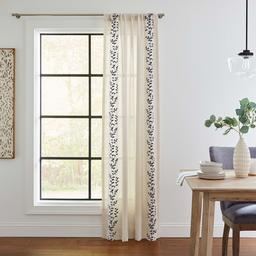

│ Title:    Stone & ♛ Marbury 84 Poutre de Traitement pour fenêtre Bleu Marine
│ Category: HOME_BED_AND_BATH
│ Caption:  a wooden table
│ Bullets:  None
────────────────────────────────────────────────────────────────────────────────


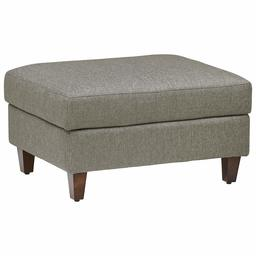

│ Title:    Amazon Brand – Stone & Beam Andover Modern Rectangle Ottoman, 32"W, Grey
│ Category: OTTOMAN
│ Caption:  a gray ottoman with wooden legs and a small foot stool
│ Bullets:  81.28 cm 宽 x 63.50 cm 深 x 53.34 cm 高；座椅深度：63.50 cm 深；座椅靠背高度：53.34 cm 高；腿高度：10.80 cm 高 | 硬木松木框架上的防污聚酯面料 | 流线型设计是现代设计的标志 |
────────────────────────────────────────────────────────────────────────────────


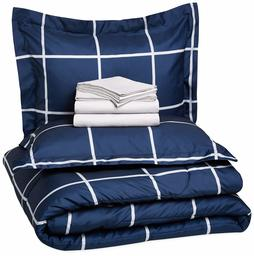

│ Title:    AmazonBasics 7-Piece Bed-in-A-Bag - Full/Queen, Navy Simple Plaid (Renewed)
│ Category: HOME_BED_AND_BATH
│ Caption:  a bed with a blue comforter and pillows
│ Bullets:  Includes 86 x 90 inch comforter, 90 x 102 inch flat sheet, 60 x 80 inch fitted sheet, two 20 x 26 inch shams, and two 20
────────────────────────────────────────────────────────────────────────────────


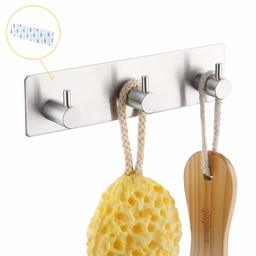

│ Title:    [Amazonブランド] Umi.(ウミ) 強力粘着フック 壁掛けフック コートフック タオル掛け キッチン 洗面所浴室 ステンレス, A7060H3-2
│ Category: HOME
│ Caption:  a picture of a pineapple hanging on a hook
│ Bullets:  【穴開け不要】：強力な粘着力があり、取り外すのも簡単です。防水設計があるので、お風呂場や洗面所などのところで使用できます。 | 【痕跡残らず】：アンカーを使うことは必要ないため、壁を傷つけません。そして取り外した後、痕跡がありません。 | 
────────────────────────────────────────────────────────────────────────────────


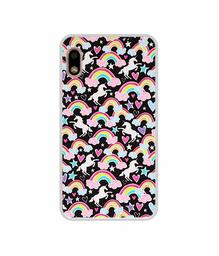

│ Title:    Amazon Brand - Solimo Designer Unicorn Texture UV Printed Soft Back Case Mobile 
│ Category: CELLULAR_PHONE_CASE
│ Caption:  unicorns and rainbows iphone case
│ Bullets:  Snug fit for Coolpad Note 6, with perfect cut-outs for volume buttons, audio and charging ports | Compatible with Coolpa
────────────────────────────────────────────────────────────────────────────────


In [79]:
# --- Preview: Show 5 sample captions with detection info ---

sample = df_caption[df_caption["image_caption"].notna()].sample(
    min(5, n_success), random_state=42
)

for _, row in sample.iterrows():
    img_path = IMAGE_BASE / str(row["path"])
    title = str(row.get("item_name_flat", "N/A"))[:80]
    caption = row["image_caption"]
    bullet = str(row.get("bullet_point_flat", "N/A"))[:120]
    category = str(row.get("product_type_flat", "N/A"))
    det_conf = row.get("detection_confidence")
    det_hit = row.get("detection_hit", False)
    det_label = f"✓ detected (conf={det_conf:.2f})" if det_hit else "✗ fallback (full image)"

    if img_path.exists():
        display(IPImage(filename=str(img_path), width=200))

    print(f"│ Title:     {title}")
    print(f"│ Category:  {category}")
    print(f"│ Detection: {det_label}")
    print(f"│ Caption:   {caption}")
    print(f"│ Bullets:   {bullet}")
    print("─" * 80)

---

## Step 4 – Caption Quality & Detection Analysis

We analyze the generated captions to assess quality and the impact of detect-then-caption:

1. **Detection hit rate** and confidence score distribution.  
2. Caption length distribution (words and characters).  
3. Most frequent caption words (word cloud).  
4. Overlap between caption vocabulary and title/bullet vocabulary.  
5. **Side-by-side comparison**: detected (cropped) vs. fallback (full image) captions.

In [ ]:
# ============================================================
# Step 4: Caption Quality Analysis
# ============================================================

captions_valid = df_caption[df_caption["image_caption"].notna()]["image_caption"]

# --- Length distributions ---
caption_word_counts = captions_valid.apply(lambda x: len(x.split()))
caption_char_counts = captions_valid.apply(len)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Word count
axes[0].hist(caption_word_counts, bins=30, color="teal", edgecolor="white", alpha=0.8)
axes[0].axvline(caption_word_counts.median(), color="red", linestyle="--",
                label=f"Median: {caption_word_counts.median():.0f} words")
axes[0].set_xlabel("Word Count")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Caption Word Count Distribution")
axes[0].legend()

# Character count
axes[1].hist(caption_char_counts, bins=30, color="coral", edgecolor="white", alpha=0.8)
axes[1].axvline(caption_char_counts.median(), color="darkred", linestyle="--",
                label=f"Median: {caption_char_counts.median():.0f} chars")
axes[1].set_xlabel("Character Count")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Caption Character Count Distribution")
axes[1].legend()

plt.suptitle("BLIP Caption Length Analysis", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"\nCaption statistics:")
print(f"  Mean word count:   {caption_word_counts.mean():.1f}")
print(f"  Median word count: {caption_word_counts.median():.0f}")
print(f"  Min / Max:         {caption_word_counts.min()} / {caption_word_counts.max()}")

In [ ]:
# ============================================================
# Step 4a: Detection Analysis – OWL-ViT Performance
# ============================================================

# --- Detection Hit Rate ---
n_total_captioned = df_caption["image_caption"].notna().sum()
n_det_hits = df_caption["detection_hit"].sum()
n_fallback = n_total_captioned - n_det_hits

print(f"Detection Summary:")
print(f"  Total captioned:  {n_total_captioned:,}")
print(f"  OWL-ViT detected: {n_det_hits:,} ({n_det_hits/max(n_total_captioned,1):.1%})")
print(f"  Fallback (full):  {n_fallback:,} ({n_fallback/max(n_total_captioned,1):.1%})")

# --- Confidence Distribution ---
valid_confs = df_caption["detection_confidence"].dropna()

if len(valid_confs) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Confidence histogram
    axes[0].hist(valid_confs, bins=40, color="steelblue", edgecolor="white", alpha=0.85)
    axes[0].axvline(valid_confs.median(), color="red", linestyle="--",
                    label=f"Median: {valid_confs.median():.3f}")
    axes[0].axvline(DETECTION_CONFIDENCE_THRESHOLD, color="orange", linestyle=":",
                    label=f"Threshold: {DETECTION_CONFIDENCE_THRESHOLD}")
    axes[0].set_xlabel("OWL-ViT Confidence Score")
    axes[0].set_ylabel("Frequency")
    axes[0].set_title("Detection Confidence Distribution")
    axes[0].legend()

    # Detection hit rate by category (top 15)
    det_by_cat = df_caption[df_caption["image_caption"].notna()].groupby("product_type_flat").agg(
        total=("detection_hit", "count"),
        hits=("detection_hit", "sum"),
    )
    det_by_cat["hit_rate"] = det_by_cat["hits"] / det_by_cat["total"]
    det_by_cat = det_by_cat[det_by_cat["total"] >= 10].sort_values("hit_rate", ascending=True).tail(15)

    axes[1].barh(det_by_cat.index, det_by_cat["hit_rate"], color="teal", alpha=0.8)
    axes[1].set_xlabel("Detection Hit Rate")
    axes[1].set_title("OWL-ViT Hit Rate by Category (≥10 products)")
    axes[1].set_xlim(0, 1)

    plt.suptitle("OWL-ViT Object Detection Performance", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("  No valid detection confidences to plot.")

In [ ]:
# --- Word Cloud of Captions ---
from wordcloud import WordCloud

all_caption_text = " ".join(captions_valid.tolist())

wc = WordCloud(
    width=900, height=400,
    background_color="white",
    max_words=150,
    colormap="viridis",
    random_state=42,
).generate(all_caption_text)

fig, ax = plt.subplots(figsize=(14, 6))
ax.imshow(wc, interpolation="bilinear")
ax.axis("off")
ax.set_title("Word Cloud \u2013 BLIP Image Captions", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# --- Top 20 most frequent caption phrases ---
from collections import Counter

# Count full captions (many will be similar for similar products)
caption_counts = Counter(captions_valid.tolist())
top_20 = caption_counts.most_common(20)

print("Top 20 Most Frequent Captions:")
print("-" * 60)
for i, (caption, count) in enumerate(top_20, 1):
    print(f"  {i:2d}. [{count:4d}x] {caption[:80]}")

# Unique caption ratio
n_unique = len(set(captions_valid.tolist()))
print(f"\nUnique captions: {n_unique:,} / {len(captions_valid):,} ({n_unique/len(captions_valid):.1%})")
print(f"Caption diversity score: {n_unique/len(captions_valid):.3f}")

In [ ]:
# --- Caption vs. Existing Text Overlap ---
# Do captions add NEW information beyond what title/bullets already provide?


def jaccard_similarity(text_a: str, text_b: str) -> float:
    """Compute Jaccard similarity between two texts (word-level).

    Args:
        text_a: First text.
        text_b: Second text.

    Returns:
        Jaccard index (0 to 1).
    """
    words_a = set(str(text_a).lower().split())
    words_b = set(str(text_b).lower().split())
    if not words_a or not words_b:
        return 0.0
    intersection = words_a & words_b
    union = words_a | words_b
    return len(intersection) / len(union)


# Compute overlap for products that have both caption and bullet_point
overlap_df = df_caption[
    df_caption["image_caption"].notna() & df_caption["bullet_point_flat"].notna()
].copy()

if len(overlap_df) > 0:
    overlap_df["caption_vs_bullet_jaccard"] = overlap_df.apply(
        lambda r: jaccard_similarity(r["image_caption"], r["bullet_point_flat"]), axis=1
    )
    overlap_df["caption_vs_title_jaccard"] = overlap_df.apply(
        lambda r: jaccard_similarity(r["image_caption"], r["item_name_flat"]), axis=1
    )

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].hist(overlap_df["caption_vs_bullet_jaccard"], bins=30, color="teal",
                 edgecolor="white", alpha=0.8)
    axes[0].set_xlabel("Jaccard Similarity")
    axes[0].set_ylabel("Frequency")
    axes[0].set_title("Caption vs. Bullet Point Overlap")
    axes[0].axvline(overlap_df["caption_vs_bullet_jaccard"].median(), color="red",
                    linestyle="--",
                    label=f"Median: {overlap_df['caption_vs_bullet_jaccard'].median():.3f}")
    axes[0].legend()

    axes[1].hist(overlap_df["caption_vs_title_jaccard"], bins=30, color="coral",
                 edgecolor="white", alpha=0.8)
    axes[1].set_xlabel("Jaccard Similarity")
    axes[1].set_ylabel("Frequency")
    axes[1].set_title("Caption vs. Product Title Overlap")
    axes[1].axvline(overlap_df["caption_vs_title_jaccard"].median(), color="darkred",
                    linestyle="--",
                    label=f"Median: {overlap_df['caption_vs_title_jaccard'].median():.3f}")
    axes[1].legend()

    plt.suptitle("Do Captions Add New Information?", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

    print(f"\nOverlap analysis ({len(overlap_df):,} products with both caption + bullet):")
    print(f"  Caption vs Bullet Jaccard:  mean={overlap_df['caption_vs_bullet_jaccard'].mean():.3f}")
    print(f"  Caption vs Title Jaccard:   mean={overlap_df['caption_vs_title_jaccard'].mean():.3f}")
    print(f"  \u2192 Low overlap = captions provide COMPLEMENTARY information \u2713")
else:
    print("Insufficient data for overlap analysis.")

**Observations \u2013 Caption Quality**

- *Populate after running:*
  - **Detection hit rate:** What % of products did OWL-ViT successfully detect?
  - **Confidence distribution:** How confident is OWL-ViT on detected products?
  - **Hit rate by category:** Which product categories are easiest/hardest to detect?
  - Median caption length (words/chars).
  - Caption diversity: what % are unique?
  - Common caption patterns (e.g., \"a close up of a...\").
  - Jaccard overlap with bullets/title: low = captions add new visual info.

---

## Step 5 – CLIP Embeddings & Similarity (Optional)

We use **CLIP** to generate image embeddings and compare them with text embeddings.  
This validates that the visual content of images aligns with their captions and titles.

CLIP is not used for captioning (that's BLIP's job), but for:
- Verifying image-text alignment quality.
- Providing an alternative embedding for image-based search (future).

In [ ]:
# ============================================================
# Step 5: CLIP Embeddings & Image-Text Similarity
# ============================================================

print(f"Loading CLIP model: {CLIP_MODEL_ID}")
t0 = time.time()

clip_processor = CLIPProcessor.from_pretrained(CLIP_MODEL_ID)
clip_model = CLIPModel.from_pretrained(CLIP_MODEL_ID).to(DEVICE)
clip_model.eval()

load_time = time.time() - t0
print(f"\u2713 CLIP model loaded in {load_time:.1f}s")
print(f"  Parameters: {sum(p.numel() for p in clip_model.parameters()) / 1e6:.0f}M")

In [ ]:
# --- Compute CLIP similarity: image vs caption, image vs title ---

# Sample for speed (CLIP is slower to run on all)
clip_sample_size = min(500, len(df_caption[df_caption["image_caption"].notna()]))
df_clip = df_caption[df_caption["image_caption"].notna()].sample(
    clip_sample_size, random_state=42
).copy()

print(f"Computing CLIP similarities for {clip_sample_size} products...")

sim_caption = []
sim_title = []

for idx, row in tqdm(df_clip.iterrows(), total=len(df_clip), desc="CLIP scoring"):
    img = load_image_safe(row["path"], IMAGE_BASE)
    if img is None:
        sim_caption.append(np.nan)
        sim_title.append(np.nan)
        continue

    caption_text = str(row["image_caption"])
    title_text = str(row.get("item_name_flat", ""))[:77]  # CLIP max 77 tokens

    # Image vs Caption
    inputs_cap = clip_processor(
        text=[caption_text], images=[img], return_tensors="pt", padding=True
    ).to(DEVICE)
    with torch.no_grad():
        outputs_cap = clip_model(**inputs_cap)
    sim_cap = outputs_cap.logits_per_image.item() / 100.0  # Normalize

    # Image vs Title
    inputs_title = clip_processor(
        text=[title_text], images=[img], return_tensors="pt", padding=True
    ).to(DEVICE)
    with torch.no_grad():
        outputs_title = clip_model(**inputs_title)
    sim_ttl = outputs_title.logits_per_image.item() / 100.0

    sim_caption.append(sim_cap)
    sim_title.append(sim_ttl)

df_clip["clip_sim_caption"] = sim_caption
df_clip["clip_sim_title"] = sim_title

print(f"\n\u2705 CLIP scoring complete.")

In [ ]:
# --- Visualize CLIP similarities ---

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

valid_cap = df_clip["clip_sim_caption"].dropna()
valid_ttl = df_clip["clip_sim_title"].dropna()

axes[0].hist(valid_cap, bins=30, color="steelblue", edgecolor="white", alpha=0.8)
axes[0].axvline(valid_cap.median(), color="red", linestyle="--",
                label=f"Median: {valid_cap.median():.3f}")
axes[0].set_xlabel("CLIP Cosine Similarity")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Image vs. BLIP Caption")
axes[0].legend()

axes[1].hist(valid_ttl, bins=30, color="coral", edgecolor="white", alpha=0.8)
axes[1].axvline(valid_ttl.median(), color="darkred", linestyle="--",
                label=f"Median: {valid_ttl.median():.3f}")
axes[1].set_xlabel("CLIP Cosine Similarity")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Image vs. Product Title")
axes[1].legend()

plt.suptitle("CLIP Image-Text Alignment Scores", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"\nCLIP Similarity Summary ({clip_sample_size} products):")
print(f"  Image vs Caption:  mean={valid_cap.mean():.3f}, median={valid_cap.median():.3f}")
print(f"  Image vs Title:    mean={valid_ttl.mean():.3f}, median={valid_ttl.median():.3f}")

if valid_cap.median() > valid_ttl.median():
    print(f"  \u2192 BLIP captions align BETTER with images than titles do \u2713")
else:
    print(f"  \u2192 Titles are more descriptive than BLIP captions for this dataset")

In [ ]:
# --- Show best and worst caption matches ---

df_clip_sorted = df_clip.dropna(subset=["clip_sim_caption"]).sort_values(
    "clip_sim_caption", ascending=False
)

print("\u2550" * 80)
print("TOP 3 BEST CAPTION MATCHES (highest CLIP similarity)")
print("\u2550" * 80)
for _, row in df_clip_sorted.head(3).iterrows():
    img_path = IMAGE_BASE / str(row["path"])
    if img_path.exists():
        display(IPImage(filename=str(img_path), width=180))
    print(f"  CLIP score: {row['clip_sim_caption']:.3f}")
    print(f"  Caption:    {row['image_caption']}")
    print(f"  Title:      {str(row.get('item_name_flat', ''))[:80]}")
    print("\u2500" * 80)

print()
print("\u2550" * 80)
print("TOP 3 WORST CAPTION MATCHES (lowest CLIP similarity)")
print("\u2550" * 80)
for _, row in df_clip_sorted.tail(3).iterrows():
    img_path = IMAGE_BASE / str(row["path"])
    if img_path.exists():
        display(IPImage(filename=str(img_path), width=180))
    print(f"  CLIP score: {row['clip_sim_caption']:.3f}")
    print(f"  Caption:    {row['image_caption']}")
    print(f"  Title:      {str(row.get('item_name_flat', ''))[:80]}")
    print("\u2500" * 80)

**Observations \u2013 CLIP Analysis**

- *Populate after running:*
  - Are BLIP captions more aligned with images than raw titles?
  - What do poorly-matched captions look like? (generic captions for niche products?)
  - Implications for search: should we embed captions separately or concatenate with bullet_point?

---

## Step 6 – Export Enriched Dataset

We merge captions back into the full DataFrame and export as `enriched_products.csv`.  
This file is the input for the next notebook (`03_rag_prototype.ipynb`) and the production ingestion pipeline.

In [ ]:
# ============================================================
# Step 6: Export Enriched Dataset
# ============================================================

# Merge captions back into the full DF
# (df has all products; df_caption has the subset we captioned)

# Drop old columns if re-running
for col_drop in ["image_caption", "detection_confidence", "detection_hit"]:
    if col_drop in df.columns:
        df = df.drop(columns=[col_drop])

# Merge captions + detection info
merge_cols = ["item_id", "image_caption", "detection_confidence", "detection_hit"]
merge_cols = [c for c in merge_cols if c in df_caption.columns]
caption_map = df_caption[merge_cols].dropna(subset=["image_caption"])
df_enriched = df.merge(caption_map, on="item_id", how="left")

# Build the enriched text field that will be embedded for RAG
def build_enriched_text(row):
    """Concatenate available text fields into a single search document.

    Priority: title + bullet_points + image_caption + keywords.
    This is the text that will be embedded for semantic search.

    Args:
        row: DataFrame row.

    Returns:
        Concatenated text string.
    """
    parts = []
    for col in ["item_name_flat", "bullet_point_flat", "image_caption", "item_keywords_flat"]:
        val = row.get(col)
        if pd.notna(val) and str(val).strip() and str(val) != "None":
            parts.append(str(val).strip())
    return " . ".join(parts) if parts else None


df_enriched["enriched_text"] = df_enriched.apply(build_enriched_text, axis=1)

print(f"Enriched DataFrame: {df_enriched.shape[0]:,} rows \u00d7 {df_enriched.shape[1]} columns")
print(f"\nField coverage:")
for col in ["image_caption", "detection_confidence", "enriched_text", "item_name_flat", "bullet_point_flat"]:
    if col in df_enriched.columns:
        n = df_enriched[col].notna().sum()
        print(f"  {col:30s} {n:,} / {len(df_enriched):,} ({n/len(df_enriched):.1%})")

# Detection summary for enriched dataset
if "detection_hit" in df_enriched.columns:
    n_det = df_enriched["detection_hit"].sum()
    n_cap = df_enriched["image_caption"].notna().sum()
    print(f"\nDetection in enriched dataset:")
    print(f"  OWL-ViT detected (cropped): {n_det:,} / {n_cap:,} ({n_det/max(n_cap,1):.1%})")
    print(f"  Fallback (full image):      {n_cap - n_det:,} / {n_cap:,} ({(n_cap - n_det)/max(n_cap,1):.1%})")

In [ ]:
# --- Enriched text length distribution ---
enriched_word_counts = df_enriched["enriched_text"].dropna().apply(lambda x: len(x.split()))

fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(enriched_word_counts, bins=50, color="teal", edgecolor="white", alpha=0.8)
ax.axvline(enriched_word_counts.median(), color="red", linestyle="--",
           label=f"Median: {enriched_word_counts.median():.0f} words")
ax.set_xlabel("Word Count")
ax.set_ylabel("Frequency")
ax.set_title("Enriched Text Length (title + bullets + caption + keywords)", fontsize=13)
ax.legend()
plt.tight_layout()
plt.show()

print(f"Enriched text stats:")
print(f"  Mean words:   {enriched_word_counts.mean():.0f}")
print(f"  Median words: {enriched_word_counts.median():.0f}")
print(f"  P25 / P75:    {enriched_word_counts.quantile(0.25):.0f} / {enriched_word_counts.quantile(0.75):.0f}")

In [ ]:
import os
import pickle

# ============================================================
# Save all outputs to /kaggle/working/ for the next notebook
# ============================================================
# (Same pattern as 01-shoptalk-eda.ipynb cell 49)

# Define explicit output paths
OUTPUT_DIR = '/kaggle/working/'

ENRICHED_CSV_PATH = os.path.join(OUTPUT_DIR, 'enriched_products.csv')
ENRICHED_PKL_PATH = os.path.join(OUTPUT_DIR, 'enriched_products.pkl')
ENRICHED_FULL_PKL_PATH = os.path.join(OUTPUT_DIR, 'enriched_products_full.pkl')

# Select columns for export (clean subset for downstream RAG)
EXPORT_COLS = [
    "item_id", "item_name_flat", "bullet_point_flat", "item_keywords_flat",
    "product_description_flat", "brand_flat", "color_flat", "product_type_flat",
    "main_image_id", "path", "country",
    "image_caption", "detection_confidence", "enriched_text",
]
# Only include columns that exist
export_cols = [c for c in EXPORT_COLS if c in df_enriched.columns]
df_export = df_enriched[export_cols].copy()

print(f"Saving enriched dataset (Shape: {df_export.shape})...")

# 1. Save as Pickle (Recommended – preserves dtypes, lists, NaN)
df_export.to_pickle(ENRICHED_PKL_PATH)
print(f"✓ Saved Pickle: {ENRICHED_PKL_PATH}")

# 2. Save as CSV (Backup for quick inspection)
df_export.to_csv(ENRICHED_CSV_PATH, index=False, escapechar='\\')
print(f"✓ Saved CSV:    {ENRICHED_CSV_PATH}")

# 3. Save FULL enriched DF with all columns (for debugging / deeper analysis)
df_enriched.to_pickle(ENRICHED_FULL_PKL_PATH)
print(f"✓ Saved Full Pickle: {ENRICHED_FULL_PKL_PATH} ({df_enriched.shape[1]} columns)")

# Verify files on disk
print(f"\n✅ Export complete. Files in {OUTPUT_DIR}:")
for fpath in [ENRICHED_PKL_PATH, ENRICHED_CSV_PATH, ENRICHED_FULL_PKL_PATH]:
    if os.path.exists(fpath):
        size_mb = os.path.getsize(fpath) / (1024 * 1024)
        print(f"  {os.path.basename(fpath):35s} {size_mb:.1f} MB")

print(f"\n📋 Next notebook (03_rag_prototype) should load from:")
print(f"   pd.read_pickle('{ENRICHED_PKL_PATH}')")

In [ ]:
# --- Preview export ---
df_export.head(3)

---

## Summary & Key Findings

### Detect-then-Caption Results

| Metric | Value |
|--------|-------|
| Products captioned | *fill after run* |
| Success rate | *fill after run* |
| **OWL-ViT detection hit rate** | *fill after run* |
| **Median detection confidence** | *fill after run* |
| Median caption length | *fill after run* words |
| Unique captions | *fill after run* |
| Throughput | *fill after run* img/s |
| Device | *fill after run* |

### Quality Assessment

1. **Detection Rate:** *(what % of products did OWL-ViT locate?)*
2. **Caption Coverage:** *(what % of products got a caption?)*
3. **Diversity:** *(are captions varied or repetitive for similar products?)*
4. **Complementarity:** *(low Jaccard with bullets = captions add new visual info)*
5. **CLIP Alignment:** *(higher sim for captions vs titles = captions describe what\u2019s in the image)*

### Implications for RAG Pipeline

- **Enriched text** = `title + bullet_points + image_caption + keywords` (median ~X words).
- Recommended **chunk size**: 256\u2013512 tokens (based on enriched text length distribution).
- Image captions **complement** bullet_point text (low vocabulary overlap).
- Products with missing `product_description` (97.3%) now have visual text from captions.

### Model Comparison (for Documentation)

| Model | Task | Speed | Notes |
|-------|------|-------|-------|
| OWL-ViT-base | Object Detection | ~X img/s | Zero-shot product detection using title/category |
| BLIP-base | Captioning | ~X img/s | Captions cropped product region |
| CLIP-base | Similarity | ~X img/s | Validates caption quality |

---

### Next Steps

1. **`03_rag_prototype.ipynb`** (Local) \u2013 Load `enriched_products.csv` into ChromaDB; test RAG retrieval.  
2. **`04_voice_test.ipynb`** (Local) \u2013 Validate Whisper STT.  
3. **Production ingestion** (`backend/scripts/ingest_abo.py`) \u2013 Use `enriched_text` for embeddings + `image_caption` as metadata.

In [ ]:
# ============================================================
# Final Summary (auto-fill)
# ============================================================

print("=" * 60)
print("SHOPTALK DETECT-THEN-CAPTION \u2013 SUMMARY")
print("=" * 60)
print(f"Total Products:          {len(df_enriched):,}")
print(f"Products Captioned:      {df_enriched['image_caption'].notna().sum():,}")
print(f"Caption Success Rate:    {df_enriched['image_caption'].notna().mean():.1%}")

# Detection stats
if "detection_hit" in df_enriched.columns:
    n_cap = df_enriched["image_caption"].notna().sum()
    n_det = df_enriched["detection_hit"].sum()
    print(f"OWL-ViT Detection Hits:  {n_det:,} / {n_cap:,} ({n_det/max(n_cap,1):.1%})")
    print(f"Fallback (Full Image):   {n_cap - n_det:,} ({(n_cap - n_det)/max(n_cap,1):.1%})")
if "detection_confidence" in df_enriched.columns:
    valid_c = df_enriched["detection_confidence"].dropna()
    if len(valid_c) > 0:
        print(f"Median Det. Confidence:  {valid_c.median():.3f}")

if 'caption_word_counts' in dir():
    print(f"Median Caption Words:    {caption_word_counts.median():.0f}")
if 'n_unique' in dir():
    print(f"Unique Captions:         {n_unique:,}")
print(f"Enriched Text Coverage:  {df_enriched['enriched_text'].notna().mean():.1%}")
if 'enriched_word_counts' in dir():
    print(f"Median Enriched Words:   {enriched_word_counts.median():.0f}")
print(f"Device Used:             {DEVICE} ({GPU_NAME})")
print(f"Output Dir:              {OUTPUT_DIR}")
print(f"Output Files:            enriched_products.pkl, enriched_products.csv")
print("=" * 60)
print(f"\n\u2705 Detect-then-caption complete. Proceed to RAG prototype notebook.")
print(f"   Load with: pd.read_pickle('{ENRICHED_PKL_PATH}')")